# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Functions

In [144]:
# function to get single breath (id must exist...there are some that are missing)
# also once removed u_out=1, lengths are not always 30 (some 28, etc)
def get_breath(df,my_id):
    return df[df.breath_id == my_id] 

In [145]:
def plot_breath(df,my_id):
    id1 = get_breath(df,my_id)
    r = id1.R.iloc[0]
    c = id1.C.iloc[0]
    plt.figure(figsize=(8,5))
    plt.plot(id1.pressure,label='pressure')
    plt.plot(id1.u_in,label='u_in')
    plt.title(f'Pressure and u_in for Breath id={my_id}, R={r}, C={c}')
    plt.legend();

# Load Files

In [5]:
%%time
# Load files
train = pd.read_csv(r'F:\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\train.csv')
test = pd.read_csv(r'F:\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\test.csv')

y = train['pressure']


Wall time: 10.7 s


In [6]:
print(f'Train memory usage: {train.memory_usage().sum()}')
print(f'Test memory usage: {test.memory_usage().sum()}')

Train memory usage: 386304128
Test memory usage: 225344128


# Memory Reduction

In [7]:
# down convert columns to save memory...
# probably do float64's too

# train
train['id'] = train['id'].astype(np.int32)
train['breath_id'] = train['breath_id'].astype(np.int32)
train['R'] = train['R'].astype(np.int8)  #or OHC?
train['C'] = train['C'].astype(np.int8)
train['u_out'] = train['u_out'].astype(np.int8)
train['u_in'] = train['u_in'].astype(np.float32)
train['time_step'] = train['time_step'].astype(np.float32)


#test
test['id'] = test['id'].astype(np.int32)
test['breath_id'] = test['breath_id'].astype(np.int32)
test['R'] = test['R'].astype(np.int8)  #or OHC?
test['C'] = test['C'].astype(np.int8)
test['u_out'] = test['u_out'].astype(np.int8)
test['u_in'] = test['u_in'].astype(np.float32)
test['time_step'] = test['time_step'].astype(np.float32)

for col in test.columns:
    print(test[col].dtype)

int32
int32
int8
int8
float32
float32
int8


In [168]:
print(f'Train memory usage: {train.memory_usage().sum()}')
print(f'Test memory usage: {test.memory_usage().sum()}')


Train memory usage: 162972128
Test memory usage: 76456128


# Split data into inhalitory and exhalitory phase (only scored on inhale)

In [9]:
train_in = train[train.u_out == 0]
test_in = test[test.u_out == 0]
y_in = train_in['pressure']

train_out = train[train.u_out == 1]
test_out = test[test.u_out == 1]

In [112]:
train_in.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509277,0,7.876254
3,4,1,20,50,0.101542,22.808823,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


#  Add Features

    1. Apply lag shift (tested shift =1 ) 
        Shift = 2 performs better (2.37 vs. 2.0x)
    2. Add differentials for dt and du_in
    3. Add integral column for d_uin



In [ ]:
# apply lag shift in training set
u_in_lag = train_in.u_in.shift(1,fill_value=0)
train_in['u_in_lag'] = u_in_lag
train_in.drop(['u_in'],axis=1,inplace=True)

# and for test set
u_in_lag = test_in.u_in.shift(1,fill_value=0)
test_in['u_in_lag'] = u_in_lag
test_in.drop(['u_in'],axis=1,inplace=True)

### Add integral column

In [126]:
# make an index of breaths
train_breath_idx = train_in.breath_id.unique()
test_breath_idx = test_in.breath_id.unique()
len(test_breath_idx)


50300

In [138]:
# function that creates the derivative and integral features
# can send either test or train to...

def make_deriv_int_features(df,prefix='train'):

    dt_vals = np.zeros(len(df))
    u_in_integ = np.zeros(len(df))
    u_in_slope = np.zeros(len(df))

    start_idx = 0
    end_idx = 0
    
    # make an index of breaths
    breath_idx = df.breath_id.unique()

    for breath in breath_idx:
    
        num_vals = len(df.breath_id[df.breath_id == breath])
        end_idx = start_idx + num_vals

        u_in_vals = df.u_in[df.breath_id == breath]
        time_vals = df.time_step[df.breath_id == breath]
    
        #print('one')

        # create numpy arrays for derivative and integral values
        dt = np.zeros(num_vals)
        du_in = np.zeros(num_vals)
        integ = np.zeros(num_vals)
   
        # fill in first value of arrays (post)
        dt[0] = time_vals.iloc[1] - time_vals.iloc[0]
        du_in[0] = 0  # extrapolate?
        integ[0] = 0  # start with avg starting value of pressure?
    
        #print('two')
        # loop over breaths
        for i in range(num_vals-1):
            dt[i+1] = time_vals.iloc[i+1] - time_vals.iloc[i]
            du_in[i+1] = u_in_vals.iloc[i+1] - u_in_vals.iloc[i] 
            integ[i+1] = integ[i] + u_in_vals.iloc[i]*dt[i]#(id1.dt.iloc[0]*id1.lag.iloc[i+1] * (c/r)) *-.3*np.log(id1.time_step.iloc[i+1]*1)
    
        #print('three')
        dt_vals[start_idx:end_idx] = dt
        u_in_slope[start_idx:end_idx] = du_in
        u_in_integ[start_idx:end_idx] = integ

        start_idx = end_idx
    
    
    df['dt'] = dt_vals
    df['du_in'] = u_in_slope
    df['u_in_integ'] = u_in_integ
    
    #np.save('dt_vals_'+label,dt_vals)
    #np.save('u_in_slope_'+label,u_in_slope)
    #np.save('u_in_integ_'+label,u_in_integ)
    
    #r = id1.R.iloc[0]
    #c = id1.C.iloc[0]
    

Wall time: 0 ns


In [164]:
make_deriv_int_features(test_in,prefix='train')
make_deriv_int_features(test_in,prefix='test')


<timed exec>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TypeError: _save_dispatcher() missing 2 required positional arguments: 'file' and 'arr'

In [171]:
test_in

,id,breath_id,R,C,time_step,u_in,u_out,dt,du_in,u_in_integ
0,1,0,5,20,0.000000,0.000000,0,0.031904,0.000000,0.000000
1,2,0,5,20,0.031904,7.515046,0,0.031904,7.515046,0.000000
2,3,0,5,20,0.063827,14.651675,0,0.031924,7.136630,0.239758
3,4,0,5,20,0.095751,21.230610,0,0.031924,6.578935,0.707491
4,5,0,5,20,0.127644,26.320955,0,0.031893,5.090345,1.385252
...,...,...,...,...,...,...,...,...,...,...
4023945,4023946,125748,20,10,0.842145,0.000000,0,0.033553,0.000000,2.302126
4023946,4023947,125748,20,10,0.875648,0.000000,0,0.033503,0.000000,2.302126
4023947,4023948,125748,20,10,0.909185,0.121375,0,0.033537,0.121375,2.302126
4023948,4023949,125748,20,10,0.943148,0.000000,0,0.033962,-0.121375,2.306197


In [177]:
test_breath_idx

array([     0,      8,     11, ..., 125746, 125747, 125748])

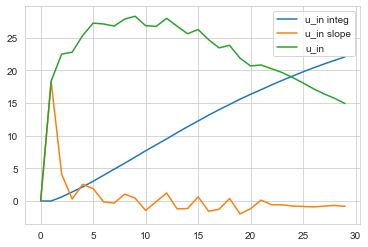

In [203]:
b1 = get_breath(train_in,1)
plt.plot(b1.u_in_integ,label='u_in integ')
plt.plot(b1.du_in,label = 'u_in slope')
plt.plot(b1.u_in, label='u_in')
#plt.plot(b1.pressure,label='pressure')
plt.legend()

In [163]:
test_in.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320955,0


In [186]:
train_in.to_pickle('train_in_w_feat')
test_in.to_pickle('test_in_w_feat')

In [204]:
# dt seems one index point off
#plt.plot(train_in.u_in_integ[0:30])
#plt.plot(train_in.du_in[0:30])


# Model

In [180]:
from sklearn.metrics import mean_absolute_error  #confusion_matrix, classification_report

In [181]:
# Split data - after all analysis is done
from sklearn.model_selection import train_test_split

train_in.drop(columns = ['pressure','id'], inplace = True)
#test = test.drop(columns = 'id', inplace = True)

X_train, X_valid, y_train, y_valid = train_test_split(train_in, y_in, train_size=0.8, test_size=0.2,
                                                      random_state=12)
X_test_in = test_in.drop(columns=['id'],inplace=False)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [182]:
# Logistic Regression - not working...yet.
X_test_in

,breath_id,R,C,time_step,u_in,u_out,dt,du_in,u_in_integ
0,0,5,20,0.000000,0.000000,0,0.031904,0.000000,0.000000
1,0,5,20,0.031904,7.515046,0,0.031904,7.515046,0.000000
2,0,5,20,0.063827,14.651675,0,0.031924,7.136630,0.239758
3,0,5,20,0.095751,21.230610,0,0.031924,6.578935,0.707491
4,0,5,20,0.127644,26.320955,0,0.031893,5.090345,1.385252
...,...,...,...,...,...,...,...,...,...
4023945,125748,20,10,0.842145,0.000000,0,0.033553,0.000000,2.302126
4023946,125748,20,10,0.875648,0.000000,0,0.033503,0.000000,2.302126
4023947,125748,20,10,0.909185,0.121375,0,0.033537,0.121375,2.302126
4023948,125748,20,10,0.943148,0.000000,0,0.033962,-0.121375,2.306197


In [211]:
%%time
from catboost import CatBoostRegressor
# loop for manual type cv
#preds = []
for i in np.arange(1,2):
#     X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, test_size=0.2,
#                                                       random_state=i)
    model_cat = CatBoostRegressor(loss_function="MAE",
                               eval_metric="MAE",
                               #task_type="GPU",
                               learning_rate=.6,
                               iterations=8000,
                               l2_leaf_reg=50,
                               random_seed=12,
                               od_type="Iter",
                               depth=5,
                               #early_stopping_rounds=6500,
                               border_count=64,
                               verbose=False
                              )
    model_cat.fit(X_train,y_train)
    pred_cat = model_cat.predict(X_valid)
    score_cat = mean_absolute_error(y_valid,pred_cat)
    #print(f'iters={i}, lr={j}, CatBoost MAE Score: {score_cat}')
    print(f'CatBoost MAE Score: {score_cat}')
    #preds.append(model_cat.predict_proba(X_test)[:,1])
    # 400, .6 = 3.976


CatBoost MAE Score: 1.1233367605809463
Wall time: 43min 1s


### Final Model

In [212]:
# create outpreds = average out value
out_preds = np.ones(len(test_out))
i = list(test_out.id)
out_preds_s = pd.Series(out_preds,index = i)
out_preds_s

32         1.0
33         1.0
34         1.0
35         1.0
36         1.0
          ... 
4023996    1.0
4023997    1.0
4023998    1.0
4023999    1.0
4024000    1.0
Length: 2496435, dtype: float64

In [213]:
pred_final = model_cat.predict(X_test_in)
# add indexs to recombine with out preds
pred_final_s = pd.Series(pred_final,index=list(test_in.id))
pred_final_s.head()

1    6.307804
2    5.894548
3    6.789139
4    7.722047
5    8.781170
dtype: float64

In [214]:
both = pred_final_s.append(out_preds_s).sort_index()
both.values

array([6.3078041 , 5.8945484 , 6.78913943, ..., 1.        , 1.        ,
       1.        ])

In [215]:
output = pd.DataFrame({'id': test.id, 'pressure': both.values})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!
